# **Неделя 11. feature engineering**

## **Домашняя работа**

Импортируем необходимые модули

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostRegressor # нужно установить библиотеку catboost
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

Загрузим датасет California Housing dataset

In [75]:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()

In [76]:
data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
data['target'] = california_housing.target

**Описание датасета:**
Датасет содержит информацию о жилых районах штата Калифорния. 20640 Записей, 8 признаков. 

**Описание признаков:**
1. *MedInc* - медианный доход домохозяйства
2. *HouseAge* - медианный возраст домов
3. *AveRooms* - среднее число комнат
4. *AveBedrms* - среднее число спален
5. *Population* - число людей, проживающих в районе
6. *AveOccup* - среднее число людей, проживающих в доме
7. *Latitude* - широта, геогр. координаты 
8. *Longitude* - долгота, геогр. координаты

**Целевая переменная:** Медианная стоимость дома в районе, единица измерения $10 тыс.

In [77]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


В этой домашней работе вам предстоит реализовывать различные гипотезы и тестировать их. 

Метрика качества - *mean_absolute_error*.

Разбиение на обучающую и тестовую выборку случайное.

Cтратегия кросс-валидации - ShuffledSplit.

**Во всех следующих заданиях нужно использовать модель, полученную с помощью *create_model()*.**

In [78]:
def create_model():
    """
    create instance of CatBoostRegressor model
    """
    return CatBoostRegressor(random_state=RANDOM_STATE, logging_level='Silent', iterations=60)


разделим выборку на обучающую и тестовую часть

In [79]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state = RANDOM_STATE, shuffle=True)

print('train size: {}'.format(train.shape[0]))
print('test size: {}'.format(test.shape[0]))

train size: 16512
test size: 4128


####  **Задание 1.** 
Попробуем обучить модель на датасете без дополнительных признаков и преобразований. Оцените качество модели на кросс-валидации. Модель нужно создать с помощью функции *create_model()*. В форме укажите значение метрики.

Разделить выборку на фолды нужно с помошью sklearn.model_selection.KFold c параметрами:
1. n_splits = 5
2. shuffle = True
3. random_state = RANDOM_STATE

Для проведения кросс-валидации можно использовать функции cross_val_score или cross_val_predict, в которые нужно передать созданный KFold. Можете попробовать сделать кросс-валидацию с помощью самого объекта KFold.

Метрика - mean_absolute_error. Кросс-валидацию необходимо проводить на train части датасета. 

*Не забудьте исключить target.*

In [80]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

model = create_model()
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)# your code here
predictions = cross_val_predict(model, train.drop('target', axis=1), train['target'],cv=kfold) # your code here 
score = cross_val_score(model, train.drop('target', axis=1), train['target'], 
                              scoring='neg_mean_absolute_error', cv=kfold).mean() #your code here

print(score)

-0.3262328783916132


In [81]:
round(-score, 2)

0.33

------------------------

В датасете есть интересные признаки - координаты районов. Координаты часто являются очень полезными, но не в исходном виде. Посмотрим, есть ли зависимость между target и расположением района.

Нарисуйте диаграмму рассеивания, в которой ось x - широта, y - долгота, окрасьте точки по значению target.  

Text(0, 0.5, 'Longitude')

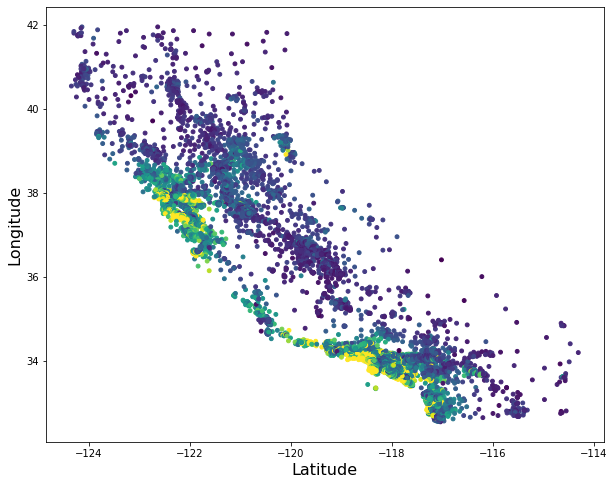

In [82]:
#your code here
plt.figure(figsize=(10,8))
plt.scatter(data['Longitude'], data['Latitude'], c=data['target'], s=15)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)

####  **Задание 2.** 

Если сопоставить диаграмму с картой штата Калифорния, то будет видно, что цены выше у крупных городов и на побережье, попробуем добавить такой признак. Посчитайте расстояние от района до следующих крупных городов:
1. Лос-Анджелес (34.05, -118.24)
2. Сан-Хосе (37.33, -121.88)
3. Сан-Франциско (37.77, -122.41)
4. Сакраменто (38.58, -121.49)

Расстояние от каждого города до района должно быть отдельным признаком.

Добавьте новые признаки в датасет, оцените качество на кросс-валидации как в 1 задании. В форме укажите значение метрики.

In [83]:
#your code here 
import geopy.distance as distance

cities = {
    'distance_LA' : (34.05, -118.24),
    'distance_SJ' : (37.33, -121.88),
    'distance_SF' : (37.77, -122.41),
    'distance_SA' : (38.58, -121.49)
}

for city in cities.keys():
    vals = []
    for coord1 in zip(data['Latitude'], data['Longitude']):
        vals.append(distance.vincenty(coord1, cities[city]).km)
    data[city] = vals

In [84]:
data.head()
model2 = create_model()
score2 = cross_val_score(model2, data.drop('target', axis=1), data['target'], 
                              scoring='neg_mean_absolute_error', cv=kfold).mean() #your code here
print(round(-score2,2))

0.32


------------------------

####  **Задание 3.** 

Можно пойти дальше и добавить еще городов или других объектов, до которых можно посчитать расстояние, но тогда число признаков может значительно вырасти, что почти всегда приводит к плохим последствиям. Преобразуем расстояния до городов в новый категориальный признак - самый близкий город.

Постройте такой признак, удалите признаки расстояний до городов и оцените качество на кросс-валидации как в 1 задании. В форме укажите значение метрики. 

Названия городов можно закодировать с помощью sklearn.preprocessing.LabelEncoder.

In [85]:
#your code here 
from sklearn.preprocessing import LabelEncoder

cols = ['distance_LA', 'distance_SJ', 'distance_SF', 'distance_SA']
city = []
for i in range(data.shape[0]): 
    city.append(cols[np.argsort(data[cols].iloc[i].values)[0]])
data['Nearest_city'] = city

le = LabelEncoder()
data['Nearest_city'] = le.fit_transform(data['Nearest_city'])

In [86]:
data.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,distance_LA,distance_SJ,distance_SF,distance_SA,Nearest_city
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,556.771371,68.421447,20.005089,101.169546,2
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,554.525608,66.044268,19.485385,102.340597,2
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,554.865611,65.892474,17.405282,104.306293,2
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,555.452104,66.323141,16.653967,104.859934,2
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,555.452104,66.323141,16.653967,104.859934,2
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697,555.452104,66.323141,16.653967,104.859934,2
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992,554.625497,65.360666,16.090437,105.722828,2
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414,554.625497,65.360666,16.090437,105.722828,2
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267,555.213785,65.806728,15.325161,106.276380,2
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611,554.625497,65.360666,16.090437,105.722828,2


In [87]:
model3 = create_model()
score3 = cross_val_score(model3, data.drop(cols+['target'], axis=1), data['target'], 
                              scoring='neg_mean_absolute_error', cv=kfold).mean() #your code here
print(round(-score3,2))

0.32


------------------------

####  **Задание 4.** 

Попробуем добавить более сложный признак. Номер кластера, в который попадает район. Постройте такой признак, оцените качество с новым признаком на кросс-валидации. В форме укажите значение метрики.

Постройте кластеризацию на всех признаках с помощью алгоритма KMeans со следующими параметрами:
1. n_clusters = 20 
2. random_state = RANDOM_STATE

Перед кластеризацией данные необходимо отмасштабировать с помощью StandartScaler. 
Масштабирование и вычисление параметров кластеризации необходимо производить на train фолдах, а применять их к train и test фолдам.

Используйте все рассчитанные ранее признаки.

In [63]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [88]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

train, test = train_test_split(data, test_size = 0.2, random_state = RANDOM_STATE, shuffle=True)
tmp = 0
scores_on_folds = []
for train_ids, test_ids in kfold.split(train): #kfold будет итеративно генерировать id train и test фолдов
    
    #разделяем выборку на train и test фолды
    train_folds = train.iloc[train_ids] 
    test_fold = train.iloc[test_ids]
    
    #создаем скейлер, алгоритм кластеризации и модель
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE)
    model = create_model()
    
    #your code here
    scaled_train = scaler.fit_transform(train_folds.drop('target', axis=1))
    scaled_test = scaler.transform(test_fold.drop('target', axis=1))
    
    kmeans_train = kmeans.fit_transform(scaled_train)
    kmeans_test = kmeans.transform(scaled_test)
    tmp = kmeans_train
    model.fit(kmeans_train, train_folds.target)
    
    predictions = model.predict(kmeans_test)
    score = mean_absolute_error(test_fold.target, predictions)
    scores_on_folds.append(score)

print('score_by_fold: {}'.format(scores_on_folds))
print('cross-validation score: {}'.format(np.mean(scores_on_folds)))

score_by_fold: [0.4491188515319665, 0.44912888234480136, 0.4426215352758932, 0.4558545210774534, 0.44616750503140085]
cross-validation score: 0.4485782590523031


In [93]:
round(np.mean(scores_on_folds),2)

0.45

------------------------

####  **Задание 5.** 

Оценивать качество на тестовой выборке стоит только в самом конце, не важно генерируем мы новые признаки или подбираем гиперпараметры модели. Если часто смотреть на метрики на тестовой выборке и делать по ним выводы, то можно переобучиться под тест. Оценка качества на тесте получится недостоверной, по ней нельзя сделать вывод о работе модели с реальными данными. 

1. Оцените качество модели на кросс-валидации на train на всех построенных в домашней работе признаках.
2. Рассчитайте признаки из домашней работы для train и test выборок.
3. Оцените качество на test, обучившись на train.

Сравните качество на кросс-валидации и test. В форме укажите разницу между значением метрики на train и cv (train_score - cv_core).

Используйте все рассчитанные раннее признаки.

In [69]:
#your code here

model5 = create_model()
model5.fit(train.drop('target', axis=1), train['target'])
preds = model5.predict(test.drop('target', axis=1))
mae = mean_absolute_error(test['target'], preds)

In [73]:
round(mae-np.mean(scores_on_folds),2)

-0.13

------------------------